In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
plt.style.use('fivethirtyeight')

PATH = "clean_data_MSK.csv"
data = pd.read_csv(PATH, sep=':')
data = data[(data['long'] < 37.9545100) & (data['long'] > 37.1813900) & (data['lat'] < 55.9825000) & (data['lat'] > 55.1339600)].copy()
data.head(2)

lighting        lat       long                     region  \
0  Светлое время суток  55.616777  37.706516  Орехово-Борисово Северное   
1  Светлое время суток  55.841157  37.489332                Головинский   

            category                 date severity  dead  injured  \
0  Наезд на пешехода  2020-03-24 13:06:00   Легкий     0        1   
1       Столкновение  2018-09-15 11:00:00   Легкий     0        1   

   n_participants  ... Пешеходы  Другое  Эксплуатация  Нарушения при движении  \
0               2  ...        0       0             0                       0   
1               2  ...        0       0             0                       0   

   Нарушение правил подачи/приема сигналов  Не пострадал  Легкие травмы  \
0                                        0             0              0   
1                                        0             0              0   

   Скончался после госпитализации  Ранения  Скончался до госпитализации  
0                               0        1                            0  
1                               0        0                            0  

[2 rows x 99 columns]

### Embeddings constraction based on time series:

In [60]:
def sev2num(x):
    if x=='Легкий':
        return 0
    elif x=='Тяжёлый':
        return 1
    elif x=='С погибшими':
        return 2

data.severity = data.severity.apply(lambda x: sev2num(x))
data.head(3)

lighting        lat       long  \
0                       Светлое время суток  55.616777  37.706516   
1                       Светлое время суток  55.841157  37.489332   
2  В темное время суток, освещение включено  55.713332  37.658944   

                      region           category                 date  \
0  Орехово-Борисово Северное  Наезд на пешехода  2020-03-24 13:06:00   
1                Головинский       Столкновение  2018-09-15 11:00:00   
2                Даниловский  Наезд на пешехода  2016-04-14 21:25:00   

   severity  dead  injured  n_participants  ... Пешеходы  Другое  \
0         0     0        1               2  ...        0       0   
1         0     0        1               2  ...        0       0   
2         0     0        1               2  ...        0       0   

   Эксплуатация  Нарушения при движении  \
0             0                       0   
1             0                       0   
2             0                       0   

   Нарушение правил подачи/приема сигналов  Не пострадал  Легкие травмы  \
0                                        0             0              0   
1                                        0             0              0   
2                                        0             0              0   

   Скончался после госпитализации  Ранения  Скончался до госпитализации  
0                               0        1                            0  
1                               0        0                            0  
2                               0        1                            0  

[3 rows x 99 columns]

In [61]:
time2risk = [0.1168, 0.1174, 0.1564, 0.1296, 0.1153, 0.1293, 0.0963, 0.0562,
             0.029 , 0.0364, 0.0353, 0.0406, 0.0407, 0.0366, 0.0343, 0.0351,
             0.0352, 0.0393, 0.0447, 0.0515, 0.0494, 0.0573, 0.0778, 0.0762]

In [62]:
new_embeddings = data[['date']].copy()

day_time = data['date'].apply(lambda x: int(x.split()[1][:2])).copy()
new_embeddings["death_risk"] = [time2risk[time] for time in day_time]
new_embeddings["inAccident_risk"] = [1 if 2<=time<=6 else ( 3 if 13<=time<=21 else 2) for time in day_time]

del new_embeddings["date"]

new_embeddings.head(5)

death_risk  inAccident_risk
0      0.0366                3
1      0.0406                2
2      0.0573                3
3      0.0447                3
4      0.0406                2

### Binary-encoded values and their preprocessing 

In [63]:
cols = ['lighting', 'lat', 'long', 'region', 'category', 'date', 'severity',
       'dead', 'injured', 'n_participants', 'dr_exp', 'w_percent',
       'Температура выше +30С', 'Пасмурно', 'Туман', 'Снегопад',
       'Температура ниже -30С', 'Дождь', 'Ураганный ветер', 'Ясно', 'Метель',
       'Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств',
       'Низкие сцепные качества покрытия', 'Сухое',
       'Свежеуложенная поверхностная обработка',
       'Отсутствие временных ТСОД в местах проведения работ',
       'Иные недостатки',
       'Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта',
       'Мокрое', 'Залитое (покрытое) водой', 'Неисправное освещение',
       'Недостатки зимнего содержания', 'Отсутствие освещения',
       'Отсутствие дорожных знаков в необходимых местах',
       'Несоответствие дорожных ограждений предъявляемым требованиям',
       'Отсутствие направляющих устройств и световозвращающих элементов на них',
       'Отсутствие дорожных ограждений в необходимых местах',
       'Обработанное противогололедными материалами',
       'Недостаточное освещение', 'Нарушения в размещении наружной рекламы',
       'Со снежным накатом', 'Загрязненное', 'Не установлено',
       'Неправильное применение, плохая видимость дорожных знаков',
       'Неудовлетворительное состояние обочин', 'Заснеженное',
       'Ограничение видимости', 'Неисправность светофора',
       'Плохая видимость световозвращателей, размещенных на дорожных ограждениях',
       'Отсутствие, плохая различимость горизонтальной разметки проезжей части',
       'Отсутствие пешеходных ограждений в необходимых местах',
       'Плохая видимость светофора',
       'Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям',
       'Пыльное', 'Неудовлетворительное состояние разделительной полосы',
       'Неровное покрытие', 'Дефекты покрытия',
       'Отсутствие, плохая различимость вертикальной разметки',
       'Отсутствие тротуаров (пешеходных дорожек)', 'Гололедица',
       'Несоответствие железнодорожного переезда предъявляемым требованиям',
       'Грузовые автомобили', 'Легковые автомобили (представительские)',
       'Специализированные машины', 'Прочие ТС', 'Легковые автомобили',
       'Общественный транспорт', 'Мототранспортные средства',
       'Водитель Эксплуатация', 'Водитель Нарушения при движении',
       'Водитель Пешеходы',
       'Водитель Нарушение правил эксплуатации мототранспорта',
       'Водитель Нарушение правил безопасности при управлении',
       'Водитель Нарушение правил перевозки людей/грузов', 'Водитель Другое',
       'Водитель Нарушение правил подачи/приема сигналов',
       'Регулируемые перекрестки', 'Регулируемые пешеходные переходы',
       'Эстакада/Мост/Тоннель', 'Места скопления автотранспорта',
       'Нерегулируемые пешеходные переходы', 'Места скопления людей',
       'Нерегулируемые перекрестки', 'Иные объекты', 'Эксплуатация',
       'Нарушение правил подачи/приема сигналов', 'Другое',
       'Нарушения при движении', 'Пешеходы']

sample = data[cols].iloc[:, 12:]
sample.head()

Температура выше +30С  Пасмурно  Туман  Снегопад  Температура ниже -30С  \
0                      0         0      0         0                      0   
1                      0         1      0         0                      0   
2                      0         1      0         0                      0   
3                      0         0      0         0                      0   
4                      0         0      0         0                      0   

   Дождь  Ураганный ветер  Ясно  Метель  \
0      0                0     1       0   
1      0                0     0       0   
2      0                0     0       0   
3      0                0     1       0   
4      0                0     1       0   

   Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств  \
0                                                  0                                         
1                                                  0                                         
2                                                  0                                         
3                                                  0                                         
4                                                  0                                         

   ...  Места скопления автотранспорта  Нерегулируемые пешеходные переходы  \
0  ...                               0                                   0   
1  ...                               1                                   0   
2  ...                               1                                   1   
3  ...                               0                                   0   
4  ...                               1                                   0   

   Места скопления людей  Нерегулируемые перекрестки  Иные объекты  \
0                      0                           0             1   
1                      0                           0             1   
2                      0                           0             1   
3                      1                           0             1   
4                      0                           0             1   

   Эксплуатация  Нарушение правил подачи/приема сигналов  Другое  \
0             0                                        0       0   
1             0                                        0       0   
2             0                                        0       0   
3             0                                        0       0   
4             0                                        0       0   

   Нарушения при движении  Пешеходы  
0                       0         0  
1                       0         0  
2                       0         0  
3                       0         0  
4                       0         0  

[5 rows x 77 columns]

## EDA

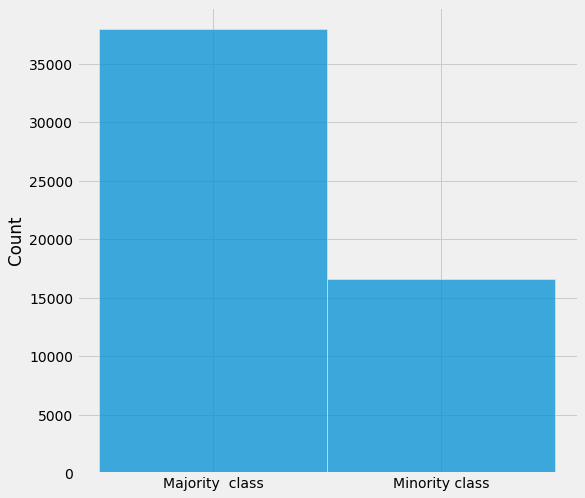

In [121]:
target = np.where(data.severity==0, 0, 1)

plt.figure(figsize=(8, 8))
sns.histplot(target, bins=2)
plt.xticks(ticks=[0.25, 0.75], labels=['Majority  class', 'Minority class'])
plt.show()

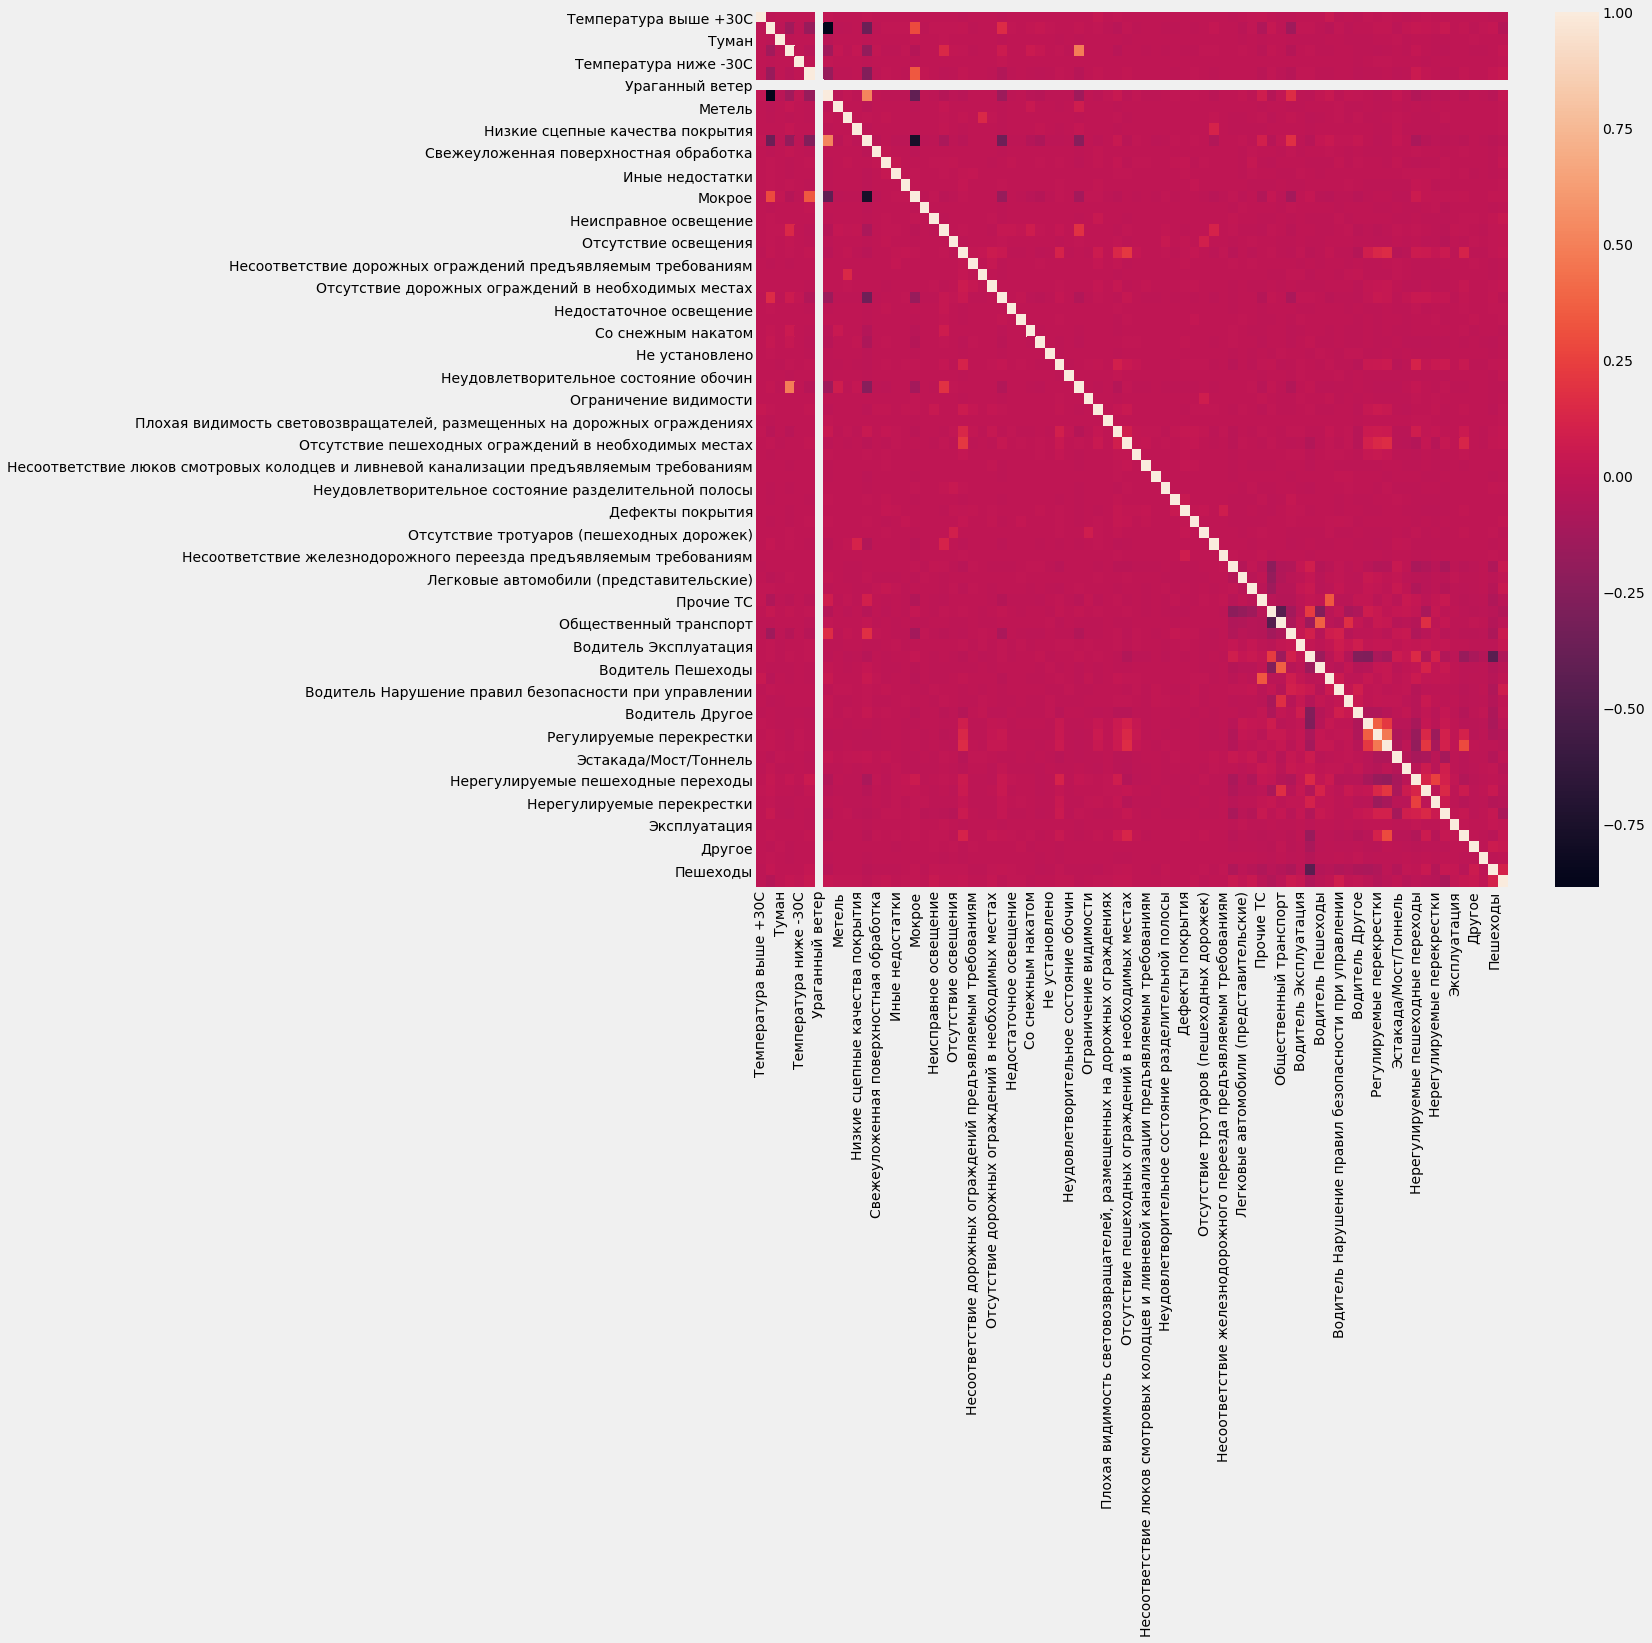

In [123]:
plt.figure(figsize=(15, 15))
sns.heatmap(pd.concat([sample, pd.Series(target)], axis=1).corr())
plt.savefig("imgs/svg_files/TSNE.svg", facecolor='white', pad_inches=0.01)
plt.savefig("imgs/png_files/TSNE.png", facecolor='white', pad_inches=0.01)
plt.show()

## TSNE visualisation

In [72]:
# select indeces to be printed
idx2plot = np.random.choice(np.arange(len(sample)), 
                            size=25000,
                            replace=False)

# select objects based on indeces
y = np.where(data.severity==0, 0, 1)[idx2plot]
idx_hard = np.where(y==1)[0]
idx_light = np.where(y==0)[0]

# make a slice of the given dataset based on indeces
dataset = sample.values[idx2plot]

In [75]:
from sklearn.manifold import TSNE

tsne = TSNE()
x = tsne.fit_transform(dataset)

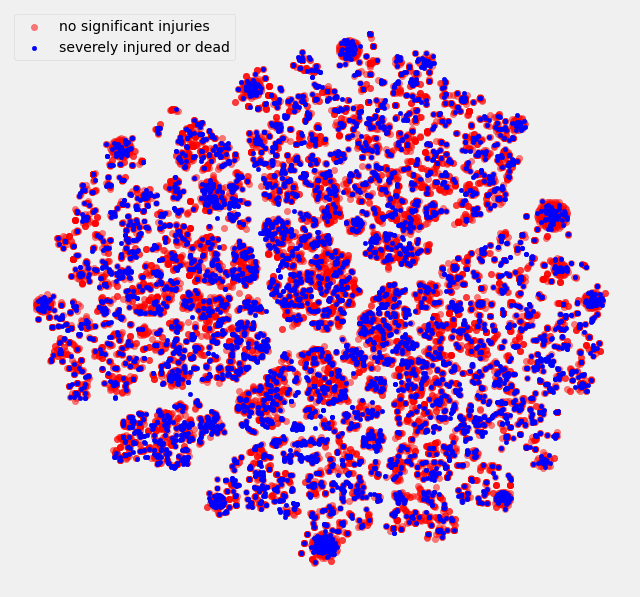

In [76]:
plt.figure(figsize=(10, 10))
plt.scatter(x[idx_light, 0], x[idx_light, 1], c='r',  s=40, alpha=0.5, label='no significant injuries')
plt.scatter(x[idx_hard, 0], x[idx_hard, 1], c='b', s=20, label='severely injured or dead')
plt.axis('off')
plt.legend()
plt.savefig("imgs/svg_files/TSNE.svg", facecolor='white', pad_inches=0.01)
plt.savefig("imgs/png_files/TSNE.png", facecolor='white', pad_inches=0.01)
plt.show()

## Plotting correlation 
### 1. without undersamplig

In [77]:
n_components=20
columns = [f'F{i+1}' for i in range(n_components)]

# performing PCA
pca = PCA(n_components=n_components)
pca_transformed = pca.fit_transform(sample.values)
pca_transformed = pd.DataFrame(columns=columns, data=pca_transformed)

In [78]:
X_full = pd.concat([pca_transformed, new_embeddings], axis=1)
y_full = np.where(data.severity==0, 0, 1)

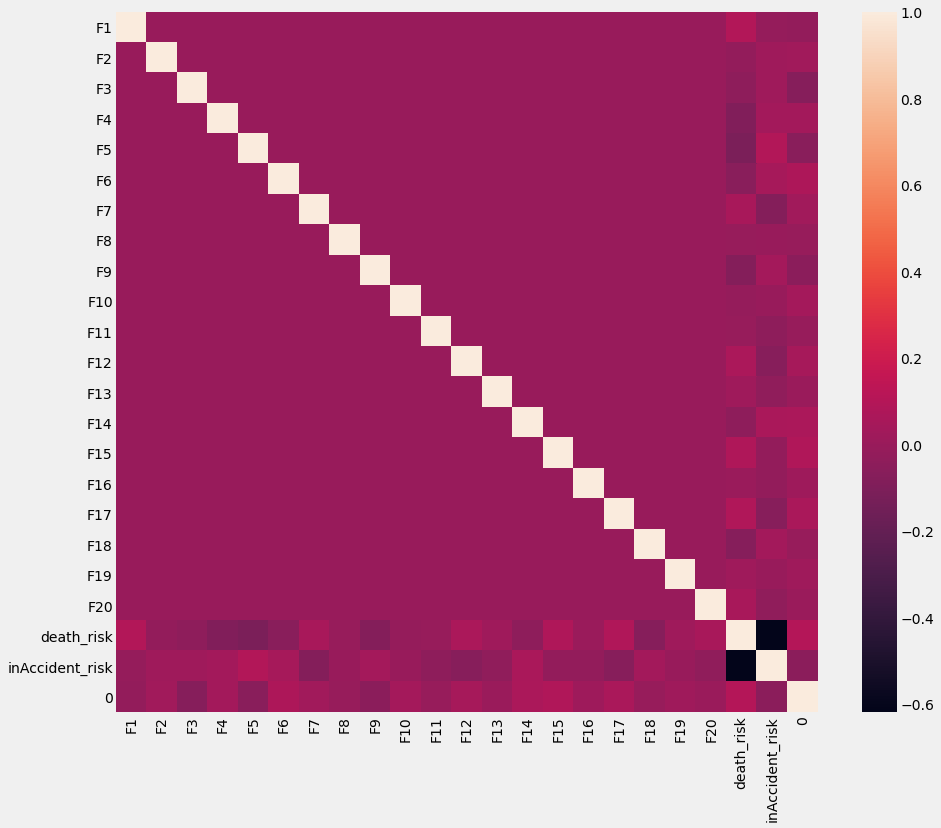

In [79]:
plt.figure(figsize=(14, 12))
sns.heatmap(pd.concat([X_full, pd.Series(y_full)], axis=1).corr())

plt.savefig("imgs/svg_files/heatmap.svg", facecolor='white', pad_inches=0.01)
plt.savefig("imgs/png_files/heatmap.png", facecolor='white', pad_inches=0.01)
plt.show()

### 1. with undersamplig

In [81]:
X4undersample = pd.concat([sample, new_embeddings], axis=1)
y4undersample = np.where(data.severity==0, 0, 1)

In [82]:
from imblearn.under_sampling import RandomUnderSampler

# performing undersampling
rus = RandomUnderSampler()
X_undersample, y_undersample = rus.fit_resample(X4undersample, y4undersample)

In [86]:
n_components=20
columns = [f'F{i+1}' for i in range(n_components)]

# performing PCA
pca = PCA(n_components=n_components)
pca_unders= pca.fit_transform(X_undersample.iloc[:, :-2])
pca_unders = pd.DataFrame(columns=columns, data=pca_unders)

corr = pd.concat([pca_unders, X_undersample.iloc[:, -2:], pd.Series(y_undersample)], axis=1).corr()
corr[[0]]

0
F1              -0.026736
F2               0.042944
F3              -0.083791
F4               0.054112
F5              -0.056604
F6               0.072599
F7               0.041540
F8              -0.011421
F9               0.047841
F10              0.027171
F11             -0.019522
F12              0.043054
F13              0.009235
F14              0.119598
F15             -0.034769
F16              0.046964
F17              0.040660
F18              0.016796
F19              0.026242
F20              0.000095
death_risk       0.103942
inAccident_risk -0.061842
0                1.000000

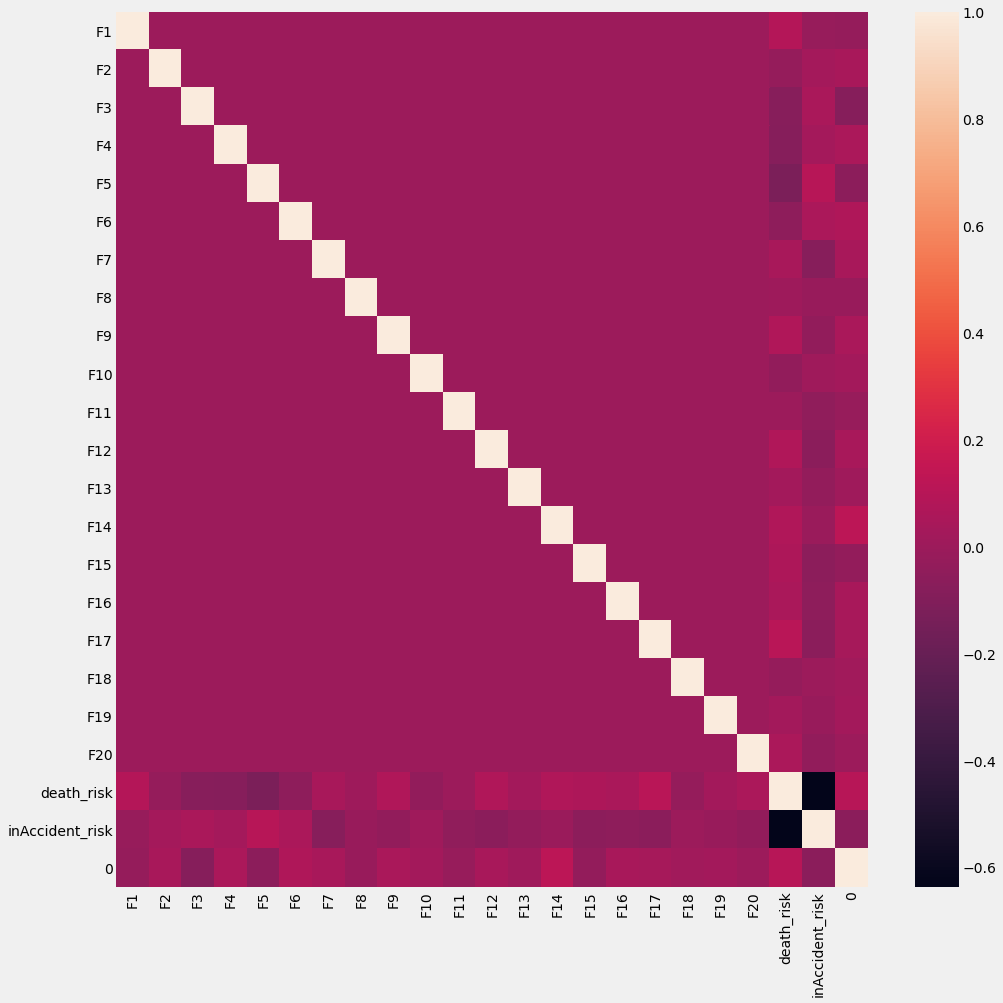

In [87]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr)

plt.savefig("imgs/svg_files/heatmap2.svg", facecolor='white', pad_inches=0.01)
plt.savefig("imgs/png_files/heatmap2.png", facecolor='white', pad_inches=0.01)
plt.show()

In [89]:
Us_df, Us_y = pd.concat([pca_unders, X_undersample.iloc[:, -2:]], axis=1).values, y_undersample

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE()
x = tsne.fit_transform(Us_df)

In [225]:
idd = np.where(Us_y==1)
idi = np.where(Us_y==0)

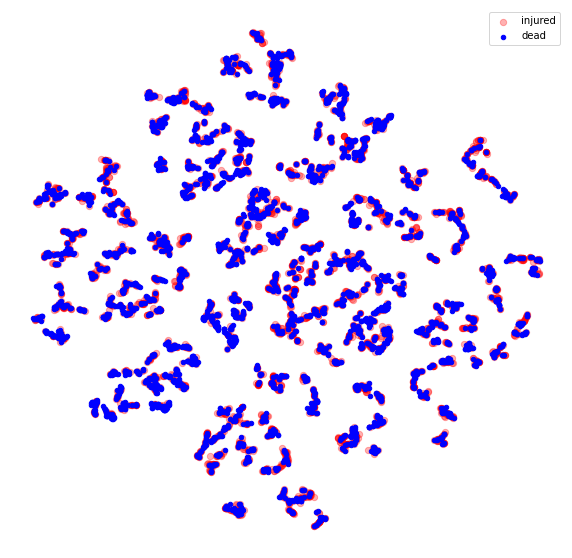

In [226]:
plt.figure(figsize=(10, 10))
plt.scatter(x[idi, 0], x[idi, 1], c='r',  s=40, alpha=0.3, label='injured')
plt.scatter(x[idd, 0], x[idd, 1], c='b', s=20, label='dead')
plt.axis('off')
plt.legend()
plt.savefig("imgs/svg_files/TSNE.svg", facecolor='white', pad_inches=0.01)
plt.savefig("imgs/png_files/TSNE.png", facecolor='white', pad_inches=0.01)
plt.show()

In [91]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score as CKS 
from sklearn.metrics import average_precision_score as APS
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from sklearn.metrics import roc_curve, accuracy_score, average_precision_score

In [96]:
n_components=20
columns = [f'F{i+1}' for i in range(n_components)]

# performing PCA
pca = PCA(n_components=n_components)
pca_unders= pca.fit_transform(sample)
pca_unders = pd.DataFrame(columns=columns, data=pca_unders)

X = pd.concat([pca_unders, new_embeddings], axis=1)
y = data['dead'].apply(lambda x: 0 if x==0 else 1)

X_tr,  X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.3)
print(X_tr.shape, X_tr.shape)

(38191, 22) (38191, 22)


In [98]:
from catboost import CatBoostClassifier

catboost_ = CatBoostClassifier(class_weights=[0.05, 0.41],
                                target_border=0.1,
                                eval_metric='AUC', 
                                verbose=False)

catboost_.fit(X_tr, y_tr, use_best_model=True, eval_set=(X_ts, y_ts))

y_pred_proba = catboost_.predict_proba(X_ts)
print('Cohen Kappa score: {:.3f}'.format(CKS(y_ts, catboost_.predict(X_ts))))

Cohen Kappa score: 0.151


In [26]:
scores={'AUC-Pr': [], 
        'Cohen-Kappa': [],
        'Recall1': [], 
        'Recall2': [], 
        'Precision1': [],
        'Precision2': []}

for i in np.linspace(0.45, 0.75, 5000):

    ans = np.where(y_pred_proba[:, 0] > i - 0.3, 0, 1)
    pr1 = np.sum(ans * y_ts) / (ans.sum() + 1e-10)
    pr2 = ((ans==0) & (y_ts==0)).sum() / (ans==0).sum()
    scores["Precision1"] += [pr1]
    scores["Precision2"] += [pr2]

    ans = np.where(y_pred_proba[:, 0] > i+0.1, 0, 1)
    rc1 = ans[np.where(y_ts==1)].sum() / np.where(y_ts==1)[0].shape[0]
    rc0 = (ans[np.where(y_ts==0)]==0).sum() / np.where(y_ts==0)[0].shape[0]
    scores["Recall1"] += [rc1]
    scores["Recall2"] += [rc0]

    ans = np.where(y_pred_proba[:, 0] > i, 0, 1)
    ckc = CKS(y_ts, ans)
    scores["Cohen-Kappa"] += [ckc]

    aps = APS(y_ts, ans)
    scores["AUC-Pr"] += [aps]

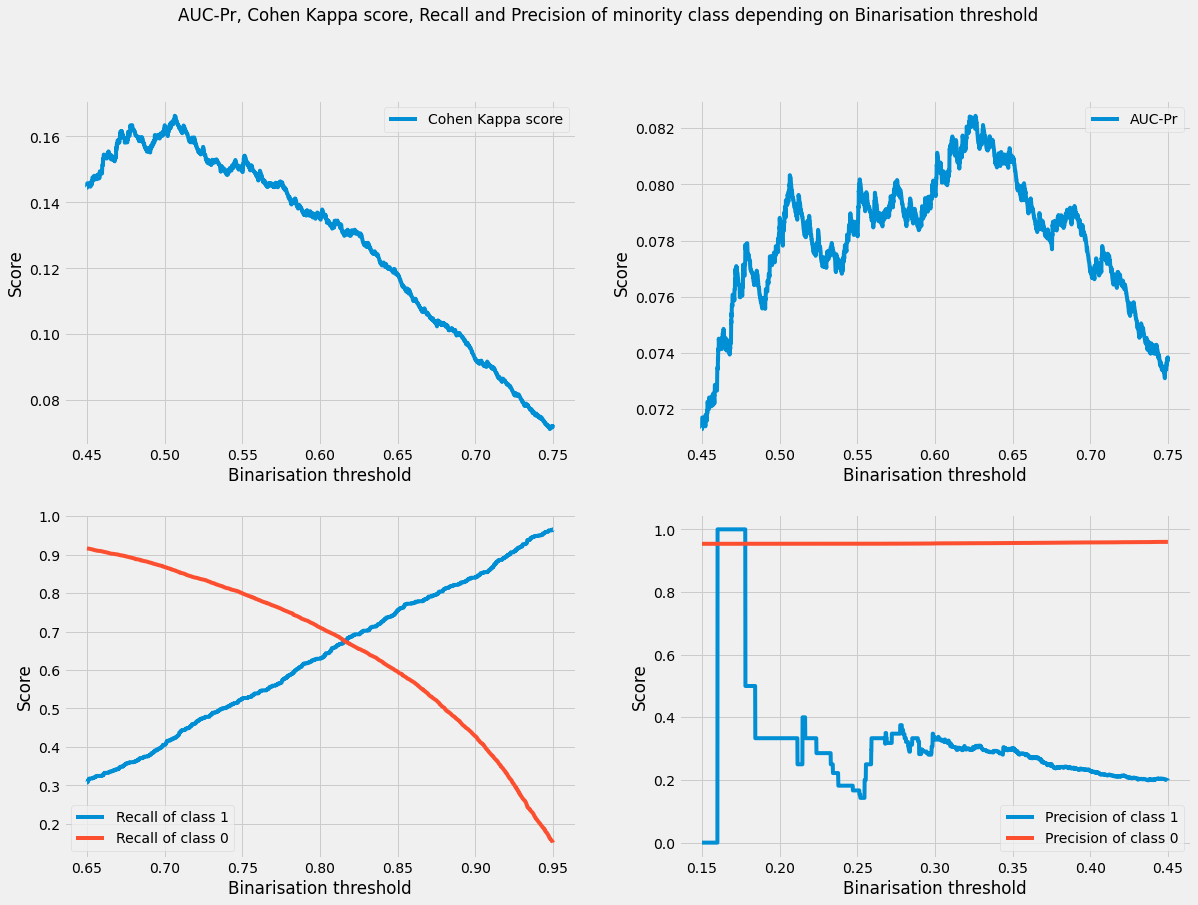

In [57]:
plt.style.use('fivethirtyeight')
_, ax, =plt.subplots(2, 2, figsize=(18, 13))

ax[0, 0].plot(np.linspace(0.45, 0.75, 5000), scores["Cohen-Kappa"], label="Cohen Kappa score")
ax[0, 0].set_xlabel("Binarisation threshold")
ax[0, 0].set_ylabel("Score")
ax[0, 0].legend()

ax[0, 1].plot(np.linspace(0.45, 0.75, 5000), scores["AUC-Pr"], label="AUC-Pr")
ax[0, 1].set_xlabel("Binarisation threshold")
ax[0, 1].set_ylabel("Score")
ax[0, 1].legend()

ax[1, 0].plot(np.linspace(0.45, 0.75, 5000) + 0.2, scores["Recall1"], label='Recall of class 1')
ax[1, 0].plot(np.linspace(0.45, 0.75, 5000)+ 0.2, scores["Recall2"], label='Recall of class 0')
ax[1, 0].set_xlabel("Binarisation threshold")
ax[1, 0].set_ylabel("Score")
ax[1, 0].legend()

ax[1, 1].plot(np.linspace(0.45, 0.75, 5000) - 0.3, scores["Precision1"], label='Precision of class 1')
ax[1, 1].plot(np.linspace(0.45, 0.75, 5000) - 0.3, scores["Precision2"], label='Precision of class 0')
ax[1, 1].set_xlabel("Binarisation threshold")
ax[1, 1].set_ylabel("Score")
ax[1, 1].legend()

plt.suptitle('AUC-Pr, Cohen Kappa score, Recall and Precision of minority class depending on Binarisation threshold')
plt.savefig("imgs/svg_files/scores.svg", facecolor='white', pad_inches=0.01)
plt.savefig("imgs/png_files/scores.png", facecolor='white', pad_inches=0.01)
plt.show()